In [2]:
import sys
sys.path.append("/home/amisery/SemesterProject")
from models.engine_nodecl import NodeClassificationEngine
from data.sfgd_datamodules import NodeCL_h5dataset
from data.plotting_utils import *

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
ckpt_path = "/home/amisery/SemesterProject/tb_logs/my_model/version_26/checkpoints/epoch=99-step=21100.ckpt"
model = NodeClassificationEngine.load_from_checkpoint(ckpt_path, map_location="cpu")

In [5]:
dataset_h5 = NodeCL_h5dataset("/scratch/.amisery/out_cap_2000.h5")

In [6]:
def get_batch_from_data(dataset, idx):
    elem = dataset[idx]
    coords, label = elem["coords"], elem["values"]
    mask = torch.ones(len(coords))
    return coords[None,:], label[None,:], mask[None,:]

In [7]:
def model_inference(dataset, idx):
    coords, label, mask = get_batch_from_data(dataset,idx)
    return (torch.argmax(model(coords,mask), dim=2) +1).view(-1,1)

In [8]:
def get_attention_from_data(dataset,idx):
    coords, label, mask = get_batch_from_data(dataset,idx)
    coords = torch.stack([model.model.lin_emb(coords[:,i,:]) for i in range(coords.shape[1])], dim=1)
    out_first_layer = model.model.encoder.layers[0].get_weights(coords,mask)
    return out_first_layer

In [21]:
torch.sum(get_attention_from_data(dataset_h5,3)[0,3,:])

tensor(1., grad_fn=<SumBackward0>)

In [10]:
def display_3D_from_coords_labels(coords, vals,ax):
    # fig = plt.figure(figsize=(10,10))
    # ax = fig.add_subplot(projection='3d')
    c_list = ["yellow", "red", "blue"]
    labels = ["multi", "single", "other"]
    
    for i in range(1,4):
        cat_coords =coords[(vals==i).squeeze(1),:]
        plot = ax.scatter(cat_coords[:,0], cat_coords[:,1], cat_coords[:,2], color = c_list[i-1], edgecolor = "black", alpha = 1, label = labels[i-1])
    ax.legend()
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    return plot

In [11]:
def plot_truth_pred(dataset,model,idx):
    fig = plt.figure(figsize=(20,40))
    ax = fig.add_subplot(1,2,1,projection='3d')
    display_3D_from_coords_labels(dataset.get_raw(idx)['coords'][:,:3], dataset.get_raw(idx)["values"],ax)
    plt.title("Event #%d, %d hits, ground truth"%(idx, len(dataset.get_raw(idx)['coords'])), fontsize = 15)
    ax = fig.add_subplot(1,2,2,projection='3d')
    ax= display_3D_from_coords_labels(dataset_h5.get_raw(idx)['coords'][:,:3], model_inference(dataset,idx),ax)
    plt.title("Model Prediction", fontsize = 15)
    # plt.subplots_adjust(top=0.9, bottom=0.1, hspace=0.3)

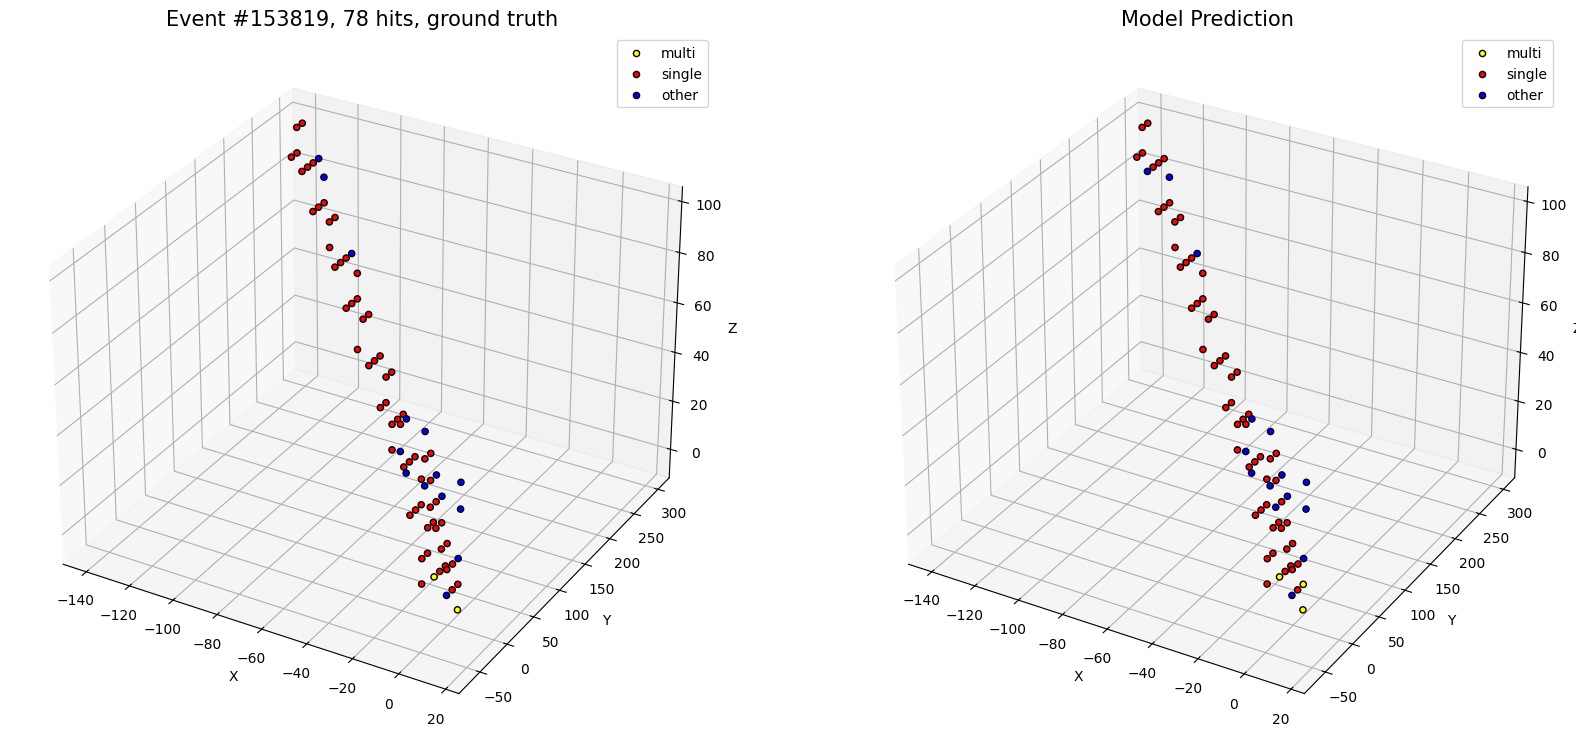

In [12]:
plot_truth_pred(dataset_h5,model,np.random.randint(len(dataset_h5)))

In [13]:
print(dataset_h5.get_raw(3)['coords'][:,:3].size())

torch.Size([216, 3])


## Visualizing Attention

In [22]:
def plot_attention(ax,dataset,model, idx, ref_point):
    # fig = plt.figure(figsize=(10,10))
    # ax = fig.add_subplot(projection='3d')
    c_list = ["yellow", "red", "blue"]
    labels = ["multi", "single", "other"]
    coords = dataset.get_raw(idx)['coords'][:,:3]
    attn = get_attention_from_data(dataset,idx)
    at_pt = attn[:,ref_point,:].squeeze(0).detach().numpy()
    print(at_pt.shape)
   
    plot = ax.scatter(coords[:,0], coords[:,1], coords[:,2], c = at_pt, cmap = "viridis",edgecolor = "black", alpha = 1, zorder = -1)
    
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.colorbar(plot, ax  = ax, use_gridspec= True,fraction=0.046, pad=0.04)
    h_s = ax.plot(coords[ref_point,0], coords[ref_point,1], coords[ref_point,2], c = "red", markersize = 15, markeredgewidth = 2, marker = 'x', zorder = 10)
    # h_s.set_offset_position('data')
    return plot

In [15]:
def plot_attn_gtruth(dataset,model,idx,refpoint):
    fig = plt.figure(figsize=(20,40))
    ax = fig.add_subplot(1,2,1,projection='3d')
    labels = ["multi particle", "single particle", "noise"]
    print(np.where(dataset.get_raw(idx)["values"]==1))
    display_3D_from_coords_labels(dataset.get_raw(idx)['coords'][:,:3], dataset.get_raw(idx)["values"],ax)
    plt.title("Event #%d, %d hits, ground truth"%(idx, len(dataset.get_raw(idx)['coords'])), fontsize = 15)
    ax = fig.add_subplot(1,2,2,projection='3d')
    refpoint_cat = dataset.get_raw(idx)["values"][refpoint]
    print(refpoint_cat.item())
    
    ax= plot_attention(ax,dataset_h5, model, idx, refpoint)
    plt.title("Attention map for a %s hit"%(labels[int(refpoint_cat-1)]), fontsize = 15)
    # plt.subplots_adjust(top=0.9, bottom=0.1, hspace=0.3)

(array([ 34,  65,  67,  70,  81,  88,  90,  97,  99, 102, 115, 116, 117,
       120, 129, 130, 147, 165, 184, 194, 215, 238, 240, 260, 285, 301,
       333, 349, 355, 365, 383, 388, 395, 417, 418, 441, 474]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
1.0
(583,)


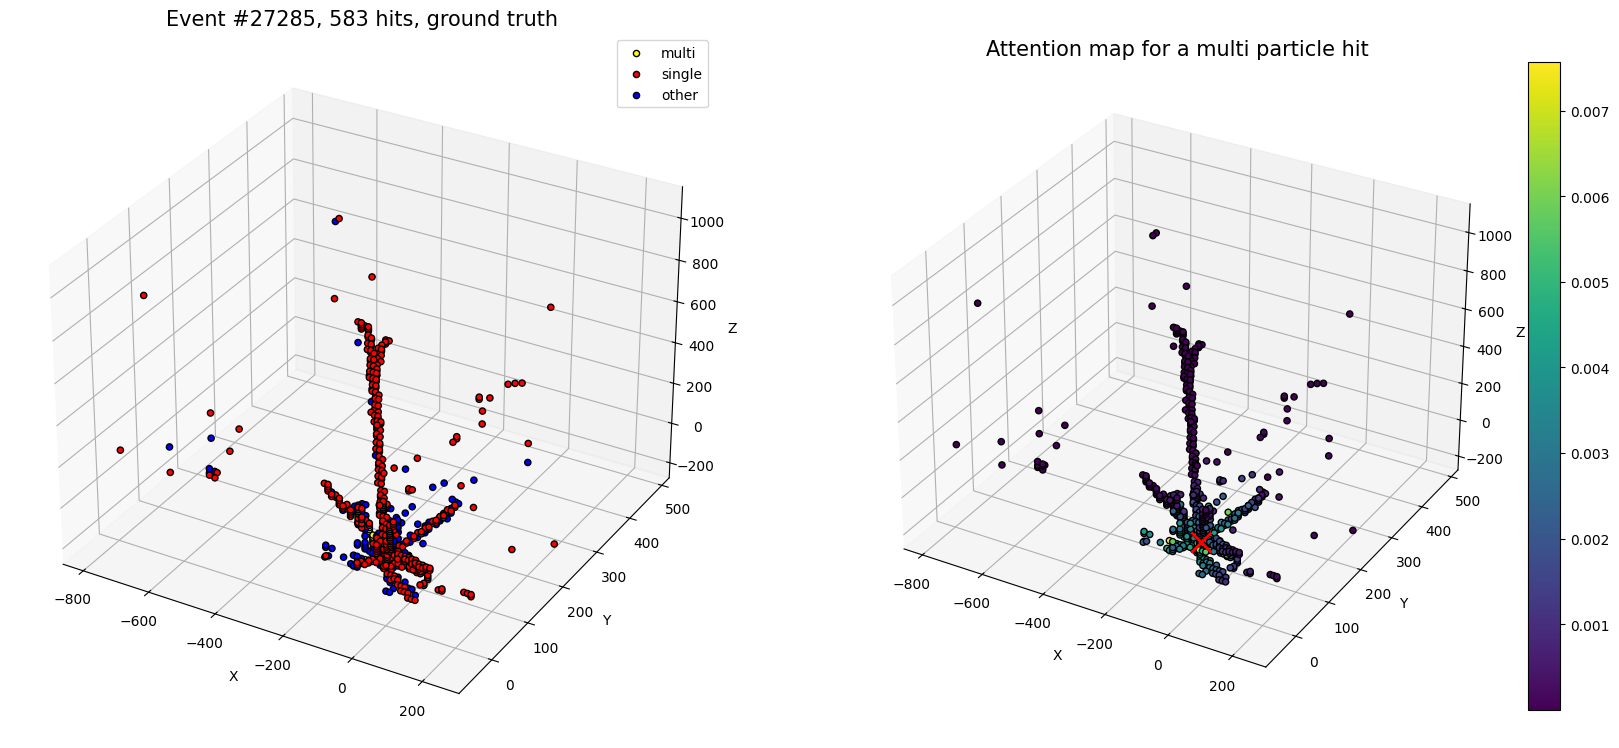

In [48]:

plot_attn_gtruth(dataset_h5,model,27285,117)

In [17]:
dataset_h5.get_raw(3)["values"].shape

torch.Size([216, 1])

In [18]:
display_3D_from_coords_labels(dataset_h5.get_raw(3)['coords'][:,:3], model_inference(dataset_h5,3))

TypeError: display_3D_from_coords_labels() missing 1 required positional argument: 'ax'